In [18]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.mplot3d import axes3d
from math import *
import random as rd
from scipy.signal import savgol_filter

plt.rcParams.update({
    "text.usetex":True,
    "xtick.labelsize":13,
    "ytick.labelsize":13,
    "axes.labelsize":17,
  "font.family": "Helvetica"
})

#Fonction pour faciliter l'utilisation des listes

def sumList(L1,L2):
    return([value1+value2 for value1,value2 in zip(L1,L2)])

def factorList(factor,L):
    return([factor*value for value in L])

In [65]:
#Définition du système

#Paramètres du système

sigma = 10
rho = 28
beta = 8/3

#Fonctions d'évolution

def f_x(state):
    [x,y,z] = state
    return(sigma*(y-x))

def f_y(state):
    [x,y,z] = state
    return(rho*x-y-x*z)

def f_z(state):
    [x,y,z] = state
    return(x*y - beta*z)
    
def f(state):
    [x,y,z] = state
    return([sigma*(y-x),rho*x-y-x*z,x*y - beta*z])

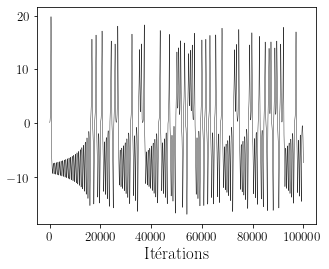

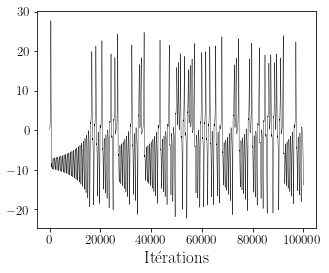

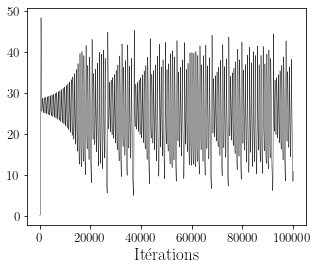

In [66]:
#Méthode RK4

def RK4(initial_state, N, dt):
    states = [initial_state]
    state = initial_state
    for i in range(1,N):
        k1 = factorList(dt,f(state))
        k2 = factorList(dt,f(sumList(state,factorList(1/2,k1))))
        k3 = factorList(dt,f(sumList(state,factorList(1/2,k2))))
        k4 = factorList(dt,f(sumList(state,k3)))
        state = sumList(state,sumList(sumList(sumList(factorList(1/6,k1),factorList(1/3,k2)),factorList(1/3,k3)),factorList(1/6,k3)))
        states.append(state)
    return(np.asarray(states))
        
#Paramètres de simulation :

N = 100000
dt=1e-3

data = RK4([0.1,0.1,0.1],N,dt)
X = data[:,0]
Y = data[:,1]
Z = data[:,2]

plt.figure(figsize=(5,4))
plt.plot(X,linewidth=0.4,color='black')
plt.xlabel('Itérations')
plt.show()

plt.figure(figsize=(5,4))
plt.plot(Y,linewidth=0.4,color='black')
plt.xlabel('Itérations')
plt.show()

plt.figure(figsize=(5,4))
plt.plot(Z,linewidth=0.4,color='black')
plt.xlabel('Itérations')
plt.show()

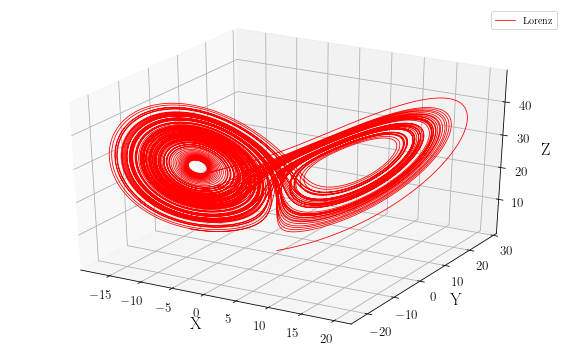

In [67]:
# Tracé du résultat en 3D
fig = plt.figure(figsize=(8,5))
ax = fig.gca(projection='3d')  #Affichage en 3D
ax.plot(X, Y, Z, label='Lorenz', color='red', linewidth=0.8)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.tight_layout()
plt.legend()
plt.show()

1


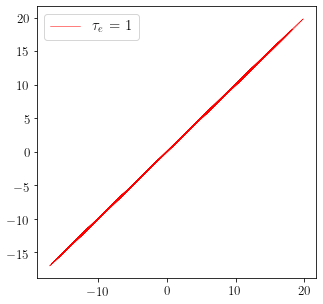

10


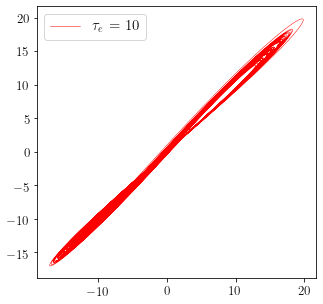

25


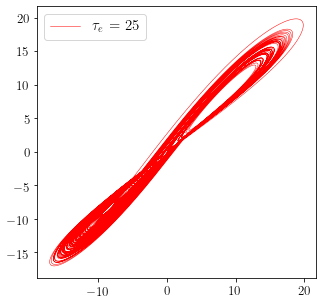

50


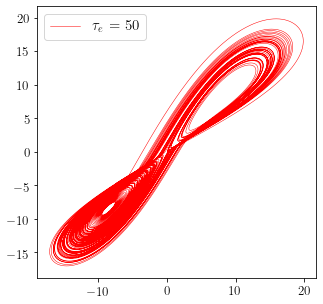

100


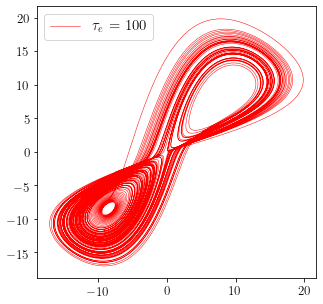

150


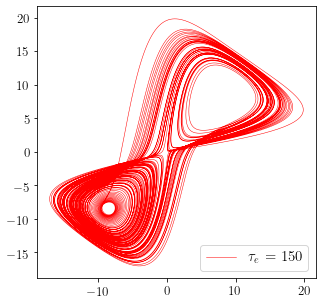

250


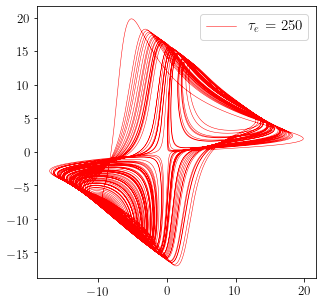

500


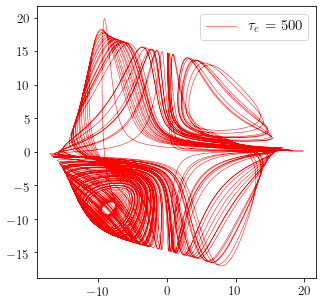

1000


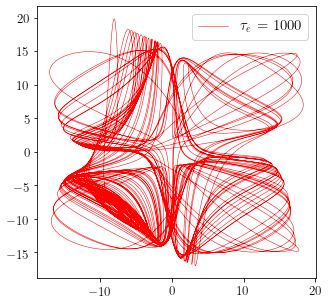

2000


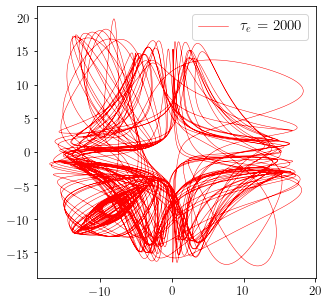

100%|██████████| 2000/2000 [01:17<00:00, 25.67it/s]


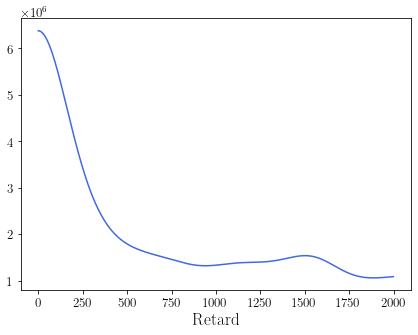

In [72]:
#Définiton de la fonction de plongement bi-dimensionnel

def plongementBi(tau_e,data):
    couples = []
    for i in range(tau_e,len(data)):
        couple = [data[i],data[i-tau_e]]
        couples.append(couple)
    return(np.asarray(couples)) #Renvoie une liste de couple pour visualiser le plongement bi-dimensionnel

#Tracés pour visualiser l'influence du paramètre tau_e

for tau_e in [1,10,25,50,100,150,250,500,1000,2000]:
    data = plongementBi(tau_e,X)
    x_plot = data[:,0]
    y_plot = data[:,1]
    print(tau_e)
    plt.figure(figsize=(5,5))
    plt.plot(x_plot,y_plot, color='red', linewidth=0.5, label=r"$\tau_e $ = {}".format(tau_e))
    plt.legend(prop={'size':15})
    plt.show()
    
#Autocorrélation pour évaluer le meilleur paramètre de retard 

def autocorr(tau,data):
    sum = 0
    for i in range(tau,len(data)):
        sum += data[i]*data[i-tau]
    return(sum)

autocorr_data = [autocorr(tau,X) for tau in tqdm(range(0,2000,1), position=0, leave=True)]
plt.figure(figsize=(7,5))
plt.plot([tau for tau in range(0,2000,1)],autocorr_data, color='Royalblue')
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.xlabel('Retard')
plt.show()

100%|██████████| 500/500 [04:33<00:00,  1.83it/s]


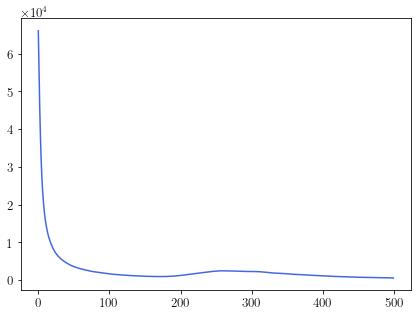

172


In [71]:
def info_mut(tau_e):
    data = plongementBi(tau_e,X) 
    x_normal = data[:,0] #Série temporelle (tronquée des tau premiers points)
    x_delayed = data[:,1] #Série temporelle (retardée de tau par rapport à la série x_normal)

    #Calcul des ddp des deux séries temporelles 

    histo = np.histogram(x_normal, bins=100, density=True)
    ddp = histo[0]
    inter = histo[1]

    #Calcul de la ddp conjointe

    histo2d = np.histogram2d(x_normal, x_delayed, bins=100, density=True)
    ddp_conj = histo2d[0]

    #Calcul de l'information mutuelle retardée

    mutual_info = 0
    for k in range(len(x_normal)): 
        x_normal_value = x_normal[k]
        x_delayed_value = x_delayed[k]
        
        #Recherche dichotomique de l'intervalle de l'histrogramme associé à x_normal_value
        a = 0 
        c = 100
        i=(c-a)//2
        while c-a > 1:
            if x_normal_value > inter[i]:
                a=i
                i = (c+a)//2
            else:
                c=i
                i = (c+a)//2
        #Recherche dichotomique de l'intervalle de l'histogramme associé à x_delayed_value
        a = 0
        c = 100
        j=(c-a)//2
        while c-a > 1:
            if x_delayed_value > inter[j]:
                a=j
                j = (c+a)//2
            else:
                c=j
                j = (c+a)//2
        if ddp_conj[i,j] < 1e-15: #pour traiter le cas 0*log(0) qui peut poser problème numériquement parlant
            mutual_info += 0
        else:
            mutual_info += ddp_conj[i,j]*log2(ddp_conj[i,j]/(ddp[i]*ddp[j]))
    '''    
    plt.figure(figsize=(7,5))
    plt.imshow(np.transpose(ddp_conj))
    plt.colorbar()
    plt.show()'''
        
    return(mutual_info)


plt.figure(figsize=(7,5))
times = [i for i in range(0,500)]
info_mut_values = [info_mut(time) for time in tqdm(times, position=0, leave=True)]
plt.plot(times, info_mut_values, color='Royalblue')
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.show()

#Recherche du premier minimum local :

i=1
while (info_mut_values[i]-info_mut_values[i-1])*(info_mut_values[i+1]-info_mut_values[i])>0:
    i+=1
print(i)

100%|██████████| 5/5 [03:55<00:00, 47.00s/it]


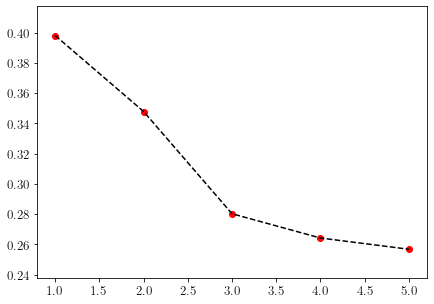

In [70]:
tau_e = 172 #meilleur délai de plongement

#Détermination de la meilleure dimension de plongement grâce à la recherche de faux voisins

def false_neighbors(X,d):
    
    #Création de tous les vecteurs d'états
    
    x_states = []
    for i in range(d*tau_e,N):
        x_state = []
        for k in range(d):
            x_state.append(X[i-(d-1-k)*tau_e])
        x_states.append(x_state)
    x_states = np.asarray(x_states)
        
    #Création d'une matrice de voisinage
    size = np.shape(x_states)[0] 
    neighbors_matrix = np.zeros((size,size))
    for i in range(0,size,1000):
        for j in range(i+1,size):
            distance = sqrt(np.max([abs(u-v) for u,v in zip(x_states[i,:],x_states[j,:])]))
            if distance < 0.8 :
                neighbors_matrix[i,j]=1
    
    #Détermination de la proportion de faux voisins
    total_neighbors = 0
    total_false_neighbors = 0
    for i in range(0,size,1000):
        for j in range(i+1,size):
            if neighbors_matrix[i,j]==1:
                total_neighbors +=1
                distance = sqrt(np.max([abs(u-v) for u,v in zip(x_states[i,:],x_states[j])]))
                distance_in_bigger_space =abs(X[i-d*tau_e]-X[j-d*tau_e])
                ratio = distance_in_bigger_space/distance
                if ratio > 10:
                    total_false_neighbors += 1
    return(total_false_neighbors/total_neighbors)
   
plt.figure(figsize=(7,5))
false_neighbors_data = [false_neighbors(X,d) for d in tqdm([1,2,3,4,5], position=0, leave=True)]
plt.scatter([1,2,3,4,5], false_neighbors_data, color='red')
plt.plot([1,2,3,4,5], false_neighbors_data, '--', color='black')
plt.show()

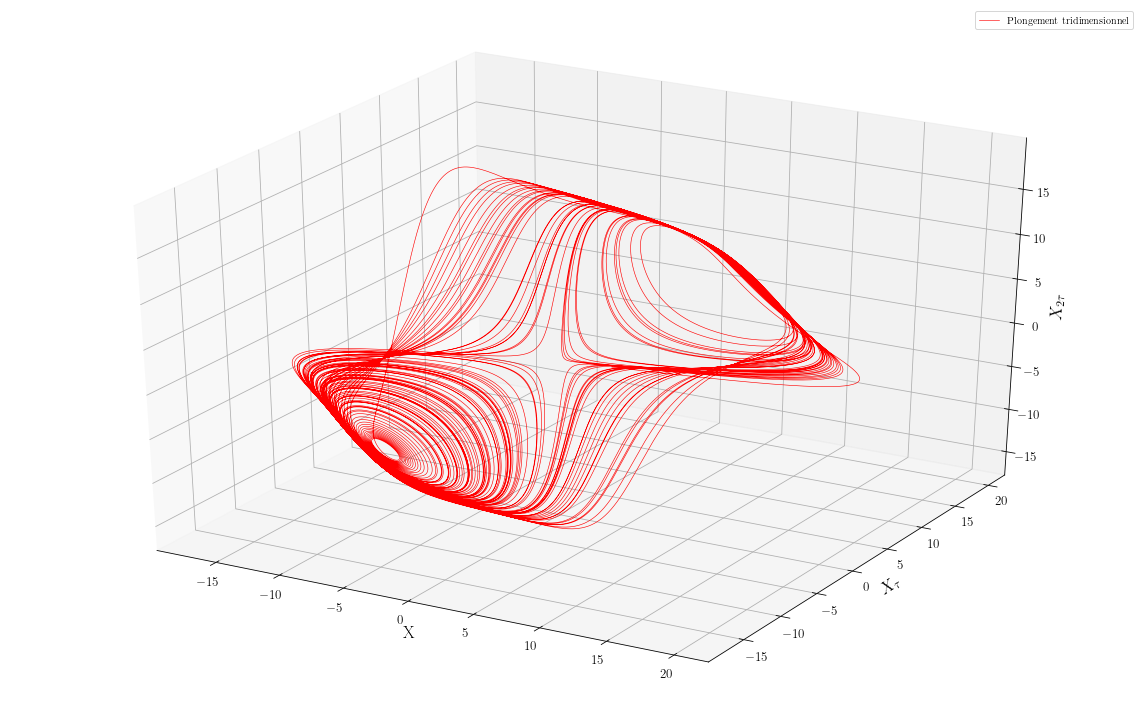

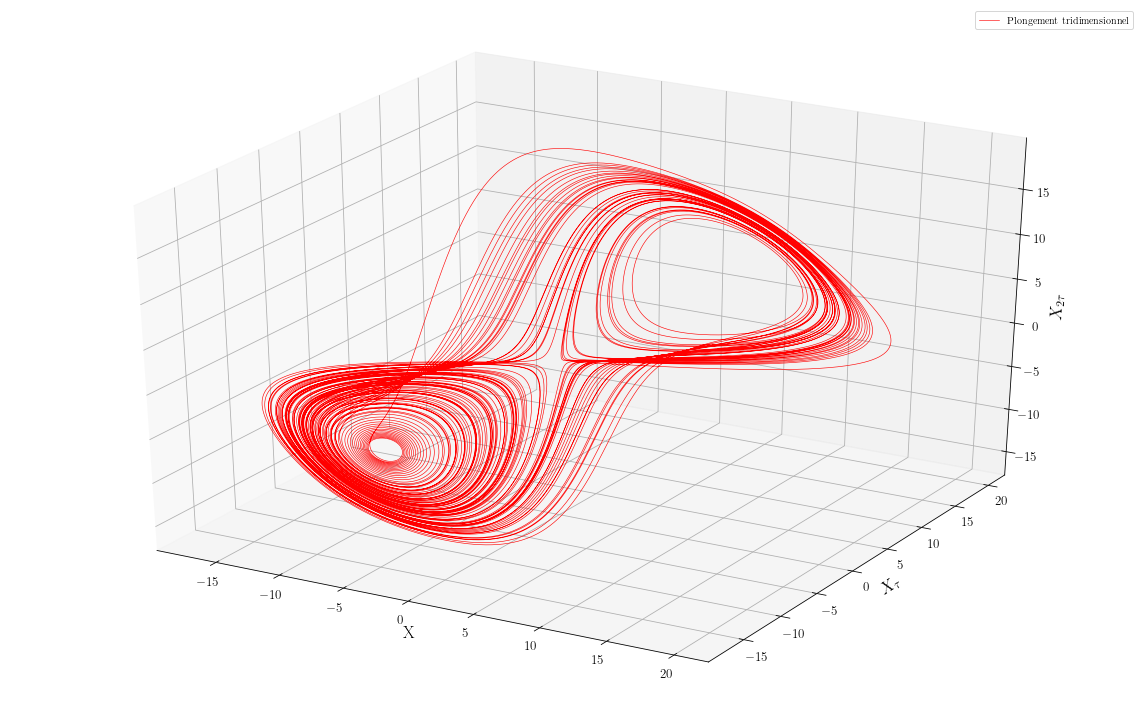

In [59]:
def plongementTri(tau_e,serie):
    triples = []
    for i in range(2*tau_e,len(serie)):
        triple = [serie[i],serie[i-tau_e], serie[i-2*tau_e]]
        triples.append(triple)
    return(np.asarray(triples)) #Renvoie une liste de triplet pour visualiser le plongement tri-dimensionnel

# Tracé du résultat en 3D

data = plongementTri(172,X)
x_normal = data[:,0]
x_tau = data[:,1]
x_2tau = data[:,2]

fig = plt.figure(figsize=(16,10))
ax = fig.gca(projection='3d')  #Affichage en 3D
ax.plot(x_normal, x_tau, x_2tau, label='Plongement tridimensionnel', color='red', linewidth=0.6)
ax.set_xlabel('X')
ax.set_ylabel(r'$X_{\tau}$')
ax.set_zlabel(r'$X_{2\tau}$')
plt.tight_layout()
plt.legend()
plt.show()

data = plongementTri(120,X)
x_normal = data[:,0]
x_tau = data[:,1]
x_2tau = data[:,2]

fig = plt.figure(figsize=(16,10))
ax = fig.gca(projection='3d')  #Affichage en 3D
ax.plot(x_normal, x_tau, x_2tau, label='Plongement tridimensionnel', color='red', linewidth=0.6)
ax.set_xlabel('X')
ax.set_ylabel(r'$X_{\tau}$')
ax.set_zlabel(r'$X_{2\tau}$')
plt.tight_layout()
plt.legend()
plt.show()

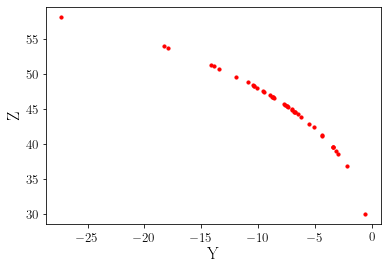

In [64]:
#Section de Poincaré


y_poincare = []
z_poincare = []

for k in range(0,len(x_normal)-1):
    if (X[k+1]*X[k] < 0) and (X[k+1]-X[k]) < 0:
        y_poincare.append(Y[k])
        z_poincare.append(Z[k])
        
plt.figure()
plt.scatter(y_poincare, z_poincare, s=10, color='red')
plt.xlabel('Y')
plt.ylabel('Z')
plt.show()

  0%|          | 0/200 [00:00<?, ?it/s]

2702
2774
1373
4004
3744
3571
5778
1150
2724
2195
1493
3647
1117
871
733
5505
5738
3912
3452


  0%|          | 1/200 [00:23<1:16:19, 23.01s/it]

987
3372
4056
3466
2604
2993
730
1429
5363
5120
4189
1023
734
1392
1339
5980
3284
3539
775
5564


  1%|          | 2/200 [00:48<1:18:09, 23.69s/it]

4467
5653
858
956
701
518
2932
1365
4550
4966
6128
755
3668
2801
5176
4096
4329
5310
5441
2890


  2%|▏         | 3/200 [01:13<1:18:47, 24.00s/it]

5299
5728
5755
5712
1830
3111
5415
3342
2267
4358
4340
3258
4309
4883
2428
5898
5795
4258
4572
248


  2%|▏         | 4/200 [01:38<1:20:14, 24.57s/it]

4828
2848
3800
2648
3249
4143
5086
3785
4950
5326
5761
5503
643
1660
723
5935
1671
5009
2579
4469


  2%|▎         | 5/200 [02:02<1:18:50, 24.26s/it]

3141
4050
4650
4083
2532
5438
3774
5810
4350
6128
1123
1064
1749
5144
543
2255
3519
4403
829
1946


  3%|▎         | 6/200 [02:25<1:17:03, 23.83s/it]

73
2185
1177
4882
2946
3141
5889
3467
1612
4118
4069
6527
2512
4247
5851
5683
1824
5749
1029
3525


  4%|▎         | 7/200 [02:48<1:15:39, 23.52s/it]

2534
5571
5459
1904
3936
1229
5125
1167
3100
4266
1867
5785
1265
1223
1740
3333
5611
2122
3967
6000


  4%|▍         | 8/200 [03:11<1:14:45, 23.36s/it]

951
4704
1330
3553
4162
2792
5505
4790
3212
4409
4120
2201
3002
1423
2885
4468
1068
5815
6142
92


  4%|▍         | 9/200 [03:33<1:13:32, 23.10s/it]

3224
5884
1020
5073
1841
4062
5488
4516
1341
6328
4712
5886
1565
3681
4865
3988
3744
4093
5213
4498


  5%|▌         | 10/200 [03:56<1:12:53, 23.02s/it]

1029
1899
5638
3801
3270
3656
3669
4559
5863
4019
1641
4015
1369
730
5079
5826
2637
2421
2242
5897


  6%|▌         | 11/200 [04:19<1:12:13, 22.93s/it]

5142
3365
5398
5458
4838
4041
1373
2046
775
5868
1133
5757
3982
1742
1364
948
4405
1761
3962
2450


  6%|▌         | 12/200 [04:41<1:11:28, 22.81s/it]

3012
5513
5782
5663
1404
5726
2258
4362
5334
3949
1109
5313
5888
4128
4471
1152
925
6024
1833
2880


  6%|▋         | 13/200 [05:05<1:12:06, 23.13s/it]

1166
3197
1159
801
5678
4600
4438
3023
1051
3572
3162
3326
5181
5755
5630
3626
3771
3758
1044
5790


  7%|▋         | 14/200 [05:29<1:12:54, 23.52s/it]

668
4150
2822
4542
3954
3279
4720
3524
5366
2231
3399
1055
5765
5990
2701
6229
6669
5750
1566
3189


  8%|▊         | 15/200 [05:52<1:11:45, 23.28s/it]

2786
4126
2599
4823
2601
5838
3188
1618
2360
1863
3818
2980
2243
5132
3906
6026
3657
3977
1741
1999


  8%|▊         | 16/200 [06:15<1:10:42, 23.06s/it]

4740
1573
1411
1916
1202
805
4731
3286
2858
5440
3959
730
4279
1477
1227
4687
2425
2830
3816
2379


  8%|▊         | 17/200 [06:37<1:09:33, 22.80s/it]

859
5720
1762
1149
2011
2781
4263
1370
5163
1682
5817
3875
466
4788
3929
3856
1671
6171
3106
3487


  9%|▉         | 18/200 [06:59<1:08:44, 22.66s/it]

4738
4837
5107
5826
4897
3033
1829
5723
2396
4002
4292
1905
4939
5129
2262
4401
1923
5134
3623
2577


 10%|▉         | 19/200 [07:22<1:08:08, 22.59s/it]

5875
1401
1032
6388
2375
4806
3041
1848
2585
6670
3895
3593
1379
2197
1319
4322
4905
1379
2184
5195


 10%|█         | 20/200 [07:44<1:07:40, 22.56s/it]

1892
5697
1325
1955
4673
4383
3520
1841
3920
3731
5241
4698
5890
4911
5587
5282
4832
4850
3389
5759


 10%|█         | 21/200 [08:07<1:07:33, 22.65s/it]

2860
2969
3891
2559
3074
1660
1152
3342
44
6082
2746
3561
4594
6665
5182
3075
1886
4818
1392
5546


 11%|█         | 22/200 [08:30<1:07:07, 22.63s/it]

728
4767
1278
4245
4130
4401
5315
4635
4587
3884
5333
4511
5532
4508
5119
5625
837
1185
4272
787


 12%|█▏        | 23/200 [08:52<1:06:42, 22.61s/it]

1397
939
2887
6246
3859
5727
3803
3892
1235
728
1318
5155
2370
5894
4694
2939
2151
1016
4600
6239


 12%|█▏        | 24/200 [09:17<1:08:21, 23.30s/it]

5040
5883
1244
2348
6141
3753
2676
2877
4682
1735
4896
4328
4598
2207
5801
6408
1432
1414
2587
5070


 12%|█▎        | 25/200 [09:42<1:09:24, 23.80s/it]

1095
5020
1422
2373
6163
1107
5502
5653
819
4391
5953
1983
3541
6030
529
3696
2113
4443
5067
4455


 13%|█▎        | 26/200 [10:06<1:09:34, 23.99s/it]

3455
4911
3154
1296
3426
1767
4777
911
5588
924
3349
4268
4134
4839
1044
5098
2453
2239
5060
1238


 14%|█▎        | 27/200 [10:30<1:08:40, 23.82s/it]

4129
4945
1045
2673
4440
1645
5198
1624
4514
2267
2893
6074
3116
4457
4647
3725
5152
4819
3755
2880


 14%|█▍        | 28/200 [10:54<1:08:46, 23.99s/it]

1658
3323
1830
4057
4432
4033
3617
4344
5752
4821
633
6674
5519
3366
4039
1471
1033
4772
723
4495


 14%|█▍        | 29/200 [11:18<1:08:20, 23.98s/it]

5089
5287
5411
1361
2851
3817
1125
5758
3403
3349
4054
4736
5609
4905
4607
3476
3251
2939
3618
1388


 15%|█▌        | 30/200 [11:42<1:07:51, 23.95s/it]

3393
2120
2858
2087
3105
2439
512
5376
1571
4682
4869
4012
758
6649
3920
2735
4239
1917
5437
3557


 16%|█▌        | 31/200 [12:06<1:07:05, 23.82s/it]

2151
3617
6458
3321
3671
3534
2492
2283
3145
5848
3625
5671
1970
1097
894
1065
3267
5062
3798
5868


 16%|█▌        | 32/200 [12:29<1:06:36, 23.79s/it]

5907
3211
1105
5735
5568
5863
5327
5449
594
5891
4507
851
2880
5319
6032
4434
4911
3478
3840
5220


 16%|█▋        | 33/200 [12:53<1:06:18, 23.82s/it]

1332
3337
2334
1595
4237
2589
4202
801
3721
4407
3501
3260
3245
1721
5057
3778
5704
4691
4792
5912


 17%|█▋        | 34/200 [13:18<1:06:31, 24.04s/it]

3440
5245
1090
3588
4901
2323
3691
4339
4922
3553
929
600
5244
2399
3901
1665
1920
4089
5506
1392


 18%|█▊        | 35/200 [13:42<1:06:16, 24.10s/it]

1682
833
4338
3500
5890
3958
4647
1618
4355
1412
4463
3608
2663
1219
3979
4738
4803
1415
1186
4613


 18%|█▊        | 36/200 [14:06<1:05:28, 23.95s/it]

4012
3922
2121
3677
1417
4625
1057
5678
1379
4963
5176
2498
3902
3725
4084
1259
1240
383
4470
5656


 18%|█▊        | 37/200 [14:29<1:04:59, 23.93s/it]

4389
4429
4080
1551
1856
4729
1828
4230
1236
3712
5738
3381
1619
2388
2227
1546
6396
1139
2493
4176


 19%|█▉        | 38/200 [14:54<1:05:01, 24.08s/it]

5896
5878
5311
466
3543
5162
1745
1574
2192
2584
741
6080
2389
995
5837
5560
3550
4034
4516
2928


 20%|█▉        | 39/200 [15:18<1:04:41, 24.11s/it]

1702
1046
5921
3794
5187
1217
5252
2569
2467
3523
4231
2376
5374
2224
1147
1340
2472
6009
4186
5677


 20%|██        | 40/200 [15:41<1:03:40, 23.88s/it]

2491
5705
5858
2487
4845
1403
5219
4325
1877
4224
851
5672
1946
4695
4599
4189
1875
2288
3269
6023


 20%|██        | 41/200 [16:04<1:02:31, 23.59s/it]

4614
3944
5681
2907
3317
4955
2731
5005
4389
4472
1045
1851
2734
2687
4281
5189
1316
857
5979
5153


 21%|██        | 42/200 [16:29<1:02:37, 23.78s/it]

4514
4114
5500
5812
2950
1038
3999
5005
2235
3760
4292
5286
5671
5659
4917
4097
5285
3933
5443
3951


 22%|██▏       | 43/200 [16:53<1:02:21, 23.83s/it]

3614
1869
3195
4844
4254
1526
1377
3989
1333
3967
3241
3618
5735
2108
4692
3893
1839
3374
1626
4229


 22%|██▏       | 44/200 [17:16<1:01:49, 23.78s/it]

1145
5723
2574
2706
5885
5781
1186
1639
997
6276
3966
2844
4087
3906
5744
5855
5160
2994
2661
4045


 22%|██▎       | 45/200 [17:39<1:01:00, 23.61s/it]

3867
5609
4990
2307
1135
3919
5327
1247
1001
1799
1646
3841
3584
3458
3037
4539
6318
3370
4865
2998


 23%|██▎       | 46/200 [18:03<1:00:30, 23.57s/it]

5093
4365
5344
4515
3453
5826
3990
4243
5858
1429
4744
6203
3752
4051
1318
2977
1039
1466
6076
3180


 24%|██▎       | 47/200 [18:26<59:51, 23.48s/it]  

3799
3386
3883
2377
2925
5259
4987
5864
5702
4719
1600
908
1114
5962
3997
3406
5872
1275
1127
2460


 24%|██▍       | 48/200 [18:50<59:23, 23.45s/it]

2228
5688
1076
4848
5920
626
5732
5989
5826
624
1172
1213
1218
1583
4932
3141
1065
3359
387
5753


 24%|██▍       | 49/200 [19:12<58:36, 23.29s/it]

2478
1839
4071
1057
1355
4018
1458
4975
5983
2793
1239
4646
4765
3548
2990
5916
3007
3988
5258
2863


 25%|██▌       | 50/200 [19:35<57:39, 23.06s/it]

1393
1656
3151
5072
4400
5947
1965
5553
5808
6185
3335
3934
5691
5002
903
3172
6258
2006
1388
1419


 26%|██▌       | 51/200 [19:58<57:04, 22.98s/it]

3722
2550
1054
3438
5895
3946
6037
2149
6219
3773
4797
1418
1087
5756
3246
5197
3834
3905
1021
5889


 26%|██▌       | 52/200 [20:20<56:22, 22.85s/it]

6454
3370
1875
2673
1309
5733
3832
4003
6546
4088
4012
3106
5678
4318
4375
1948
1862
1510
6110
3623


 26%|██▋       | 53/200 [20:43<55:54, 22.82s/it]

2685
5219
4340
4170
5382
701
1768
1267
418
4364
1455
5412
6830
5365
2433
786
5497
3443
3271
729


 27%|██▋       | 54/200 [21:06<55:24, 22.77s/it]

3937
2592
1263
2494
4562
5407
956
4630
1870
4271
2290
4795
3769
2791
4395
827
1252
5683
5471
2233


 28%|██▊       | 55/200 [21:28<54:44, 22.65s/it]

3455
650
3902
1453
5981
5447
4232
1397
4724
3335
4385
3701
6598
3989
4030
1911
2664
3963
1000
2541


 28%|██▊       | 56/200 [21:51<54:10, 22.57s/it]

4194
4085
5327
4087
4497
5663
4865
4829
4561
1644
3040
2264
4694
3193
5677
4321
4407
3962
1931
534


 28%|██▊       | 57/200 [22:13<53:43, 22.54s/it]

2375
2235
1570
1339
6757
5216
3845
3266
5899
4757
1510
4714
4453
4718
2991
5463
4682
5114
5257
3404


 29%|██▉       | 58/200 [22:36<53:22, 22.55s/it]

3641
2446
1357
5465
2067
1860
4718
2950
4664
3944
2780
5428
4288
4068
4160
4454
3411
5558
766
1844


 30%|██▉       | 59/200 [22:58<52:49, 22.48s/it]

3315
3743
2669
6552
3111
4831
514
82
1131
1456
3447
4161
1245
3562
5300
5705
1345
5947
5261
5899


 30%|███       | 60/200 [23:20<52:30, 22.50s/it]

5148
402
3374
6150
5415
2908
1605
5546
2515
3675
2276
2736
4415
3760
4087
1548
820
5326
3616
4244


 30%|███       | 61/200 [23:43<52:00, 22.45s/it]

5888
567
5263
3620
5410
561
3973
5126
5545
5781
3775
5893
4541
2808
4298
4417
1820
3191
4277
5583


 31%|███       | 62/200 [24:05<51:44, 22.50s/it]

4597
1836
5905
4568
2805
3794
1826
4254
2383
2355
3038
739
5661
5452
3796
937
5406
5843
4035
4706


 32%|███▏      | 63/200 [24:28<51:09, 22.41s/it]

1299
3127
3590
5680
1002
827
4509
2526
2564
509
4906
1864
5257
5899
3314
3052
5412
927
3927
1790


 32%|███▏      | 64/200 [24:50<50:46, 22.40s/it]

5586
829
5341
3168
1001
1379
795
4314
3020
1470
3507
1360
3957
3795
1032
3496
2203
1361
3554
2621


 32%|███▎      | 65/200 [25:12<50:18, 22.36s/it]

4416
1053
2019
844
3423
4611
4351
5185
1160
3830
259
1156
4375
1174
5538
3632
5863
4418
4903
4391


 33%|███▎      | 66/200 [25:35<49:55, 22.36s/it]

3612
5903
2861
6167
4668
1505
5661
2541
5004
791
5535
458
1160
3919
4644
3420
1976
3863
3572
4529


 34%|███▎      | 67/200 [25:57<49:40, 22.41s/it]

4685
4691
5567
4042
802
1163
5135
2408
1870
4969
2463
4709
4137
2064
1388
2996
4370
4325
5734
3104


 34%|███▍      | 68/200 [26:19<49:15, 22.39s/it]

5642
4522
2095
2329
807
782
878
1762
700
3101
1127
6301
4296
736
1815
998
1193
3907
2507
1468


 34%|███▍      | 69/200 [26:41<48:40, 22.30s/it]

1396
1265
1327
5316
6219
4099
1800
1609
5805
482
3256
1637
4552
5200
5814
4636
2196
5253
5050
1872


 35%|███▌      | 70/200 [27:04<48:21, 22.32s/it]

1204
3090
4673
1081
5249
4480
5132
5121
5971
1598
5790
6182
2000
4152
4762
5753
989
3455
2309
1739


 36%|███▌      | 71/200 [27:26<47:55, 22.29s/it]

4527
1606
2893
1194
4380
1018
161
4662
978
1938
5787
3394
3250
955
1348
2375
1930
630
4388
2759


 36%|███▌      | 72/200 [27:48<47:27, 22.25s/it]

5782
5639
4585
4094
6651
3151
4002
4720
1407
4941
7015
5736
4964
3434
3477
1609
2690
4828
4225
3770


 36%|███▋      | 73/200 [28:11<47:18, 22.35s/it]

2779
5837
1734
5518
2470
2039
5833
1260
2980
4895
1506
1426
4817
3177
4586
3144
6564
4496
1271
2998


 37%|███▋      | 74/200 [28:33<46:51, 22.32s/it]

2870
1662
4781
502
3876
5558
4326
4178
4852
3597
4465
1351
1144
1611
4166
5909
3705
5433
6127
2794


 38%|███▊      | 75/200 [28:56<46:43, 22.42s/it]

2424
981
4238
4778
4507
1302
6064
4111
5108
5929
5737
2994
1399
1208
619
4001
2230
357
4515
1353


 38%|███▊      | 76/200 [29:18<46:13, 22.37s/it]

3708
3452
3320
4529
5349
818
2514
6695
1022
46
6632
772
3336
3452
3440
2262
5115
5125
3499
3951


 38%|███▊      | 77/200 [29:40<45:47, 22.34s/it]

5815
2686
4122
3928
2167
4133
4389
1074
651
2697
375
5531
5877
1380
5871
5495
4070
5713
5553
3036


 39%|███▉      | 78/200 [30:03<45:38, 22.44s/it]

4041
6649
6034
2550
5212
4540
5626
6588
4374
2693
5581
5194
1683
2911
430
2272
4136
5084
907
3880


 40%|███▉      | 79/200 [30:26<45:22, 22.50s/it]

5141
3966
4616
1333
702
5324
2839
3812
5242
560
4740
4785
6173
5341
5441
858
1417
575
2284
2694


 40%|████      | 80/200 [30:48<44:50, 22.42s/it]

5065
5123
4698
5310
4171
4796
443
3396
3832
5280
5404
2356
778
1213
1723
6048
3862
954
5325
1195


 40%|████      | 81/200 [31:10<44:28, 22.42s/it]

1495
1204
1234
2161
3858
1979
5632
5250
3122
4932
2621
1991
3853
2357
3785
2371
1846
1311
3151
5766


 41%|████      | 82/200 [31:32<43:53, 22.32s/it]

320
3201
2395
3805
1574
4320
107
544
4997
4280
5366
5805
815
4800
5646
1144
3843
4506
527
1343


 42%|████▏     | 83/200 [31:55<43:46, 22.45s/it]

4537
3813
3752
676
3940
5369
5638
4654
556
4247
3556
4893
4697
2661
1266
4883
2023
5395
3773
4598


 42%|████▏     | 84/200 [32:17<43:09, 22.32s/it]

1560
782
4482
2552
4715
907
4484
5984
5666
4765
3440
2056
5629
4657
4202
1464
5045
5157
988
666


 42%|████▎     | 85/200 [32:39<42:35, 22.22s/it]

3251
5240
5940
2429
5036
780
1032
1621
3372
3258
3879
5530
4684
1368
2430
3658
2367
4243
3501
4028


 43%|████▎     | 86/200 [33:01<42:09, 22.19s/it]

2761
5580
1509
5404
4278
5385
2935
3560
4591
4375
5582
3415
4949
1110
1169
4331
5090
2974
3098
1391


 44%|████▎     | 87/200 [33:24<41:54, 22.25s/it]

4821
919
1587
4014
6474
3866
5160
2065
2737
2053
4633
5625
2620
1608
5100
5524
5144
1670
2714
2862


 44%|████▍     | 88/200 [33:46<41:24, 22.19s/it]

3515
2842
4882
4161
4521
4219
3392
4761
646
1316
5626
3395
1719
486
3947
939
860
6190
5256
2611


 44%|████▍     | 89/200 [34:08<40:55, 22.13s/it]

3125
967
3992
1064
4411
3346
3167
3508
2907
1008
3859
1096
1402
700
3718
1359
1094
3466
3816
5418


 45%|████▌     | 90/200 [34:29<40:24, 22.04s/it]

4886
5917
1024
3435
2478
4829
4613
2690
6055
4535
3551
5708
4949
860
5650
5695
3409
3065
5802
5313


 46%|████▌     | 91/200 [34:52<40:05, 22.07s/it]

3275
4316
5419
2380
3678
824
1458
3017
4117
5678
1705
5280
1428
6007
5807
3578
6536
1741
4921
5579


 46%|████▌     | 92/200 [35:14<39:39, 22.04s/it]

3985
2911
1013
5752
4217
5335
6128
4129
883
2856
2155
5300
3953
3308
4282
666
5718
2965
3589
5672


 46%|████▋     | 93/200 [35:36<39:24, 22.09s/it]

4266
1092
2142
2076
721
3818
1972
5937
3998
567
4399
2460
3280
5483
2118
5824
1979
3161
4706
1591


 47%|████▋     | 94/200 [35:58<38:59, 22.07s/it]

2724
1622
6152
3224
5156
2586
4602
801
5851
4375
5980
3743
5879
5616
5993
4461
2608
3574
3453
1199


 48%|████▊     | 95/200 [36:20<38:43, 22.13s/it]

1610
5728
5777
4564
3903
1183
634
1201
4015
1762
4262
2019
3418
1530
4062
642
6008
3775
1433
1611


 48%|████▊     | 96/200 [36:42<38:12, 22.04s/it]

3522
4032
5690
3956
1704
3722
1974
3091
5730
4973
4678
3633
2388
2445
1784
3242
5966
65
1547
6294


 48%|████▊     | 97/200 [37:04<37:49, 22.04s/it]

4186
5623
2990
5326
1401
4073
2515
2287
2060
3560
3866
1607
3954
4278
3839
5362
2955
5623
1125
979


 49%|████▉     | 98/200 [37:26<37:24, 22.01s/it]

2001
1308
5115
1444
871
4805
2911
2130
6037
820
656
3976
738
4456
1129
2602
2998
6058
3929
2327


 50%|████▉     | 99/200 [37:48<36:59, 21.97s/it]

4003
5254
4037
5998
1805
4250
1450
887
3832
1886
2147
5230
3227
3819
5726
893
1828
2242
4239
1934


 50%|█████     | 100/200 [38:10<36:43, 22.04s/it]

4706
3148
4400
4835
1434
5397
5943
5196
3578
2217
4924
5067
4329
5089
1194
1488
4276
3939
3411
3287


 50%|█████     | 101/200 [38:32<36:33, 22.16s/it]

5856
5666
1088
1468
6583
2724
4617
4524
2418
4967
3502
3979
3441
4251
6161
65
4621
3359
3827
5207


 51%|█████     | 102/200 [38:55<36:13, 22.18s/it]

3949
1738
2513
3118
2965
2918
5849
1043
3696
1125
384
5660
835
4024
5353
3801
5103
2751
2464
3176


 52%|█████▏    | 103/200 [39:18<36:34, 22.63s/it]

4422
1013
2968
5459
3726
5013
1234
2334
4035
6196
3007
1131
1359
1647
2608
3143
2626
5151
3606
2725


 52%|█████▏    | 104/200 [39:43<37:10, 23.24s/it]

4123
4307
5609
3884
5803
2842
5483
6251
5808
2469
5735
2998
5414
5601
4887
4400
2516
2587
1310
2292


 52%|█████▎    | 105/200 [40:06<36:29, 23.05s/it]

5600
804
1950
3571
3102
2136
5817
2332
1395
5253
4314
1215
2405
4773
4703
6288
1232
4362
6123
5383


 53%|█████▎    | 106/200 [40:28<35:44, 22.81s/it]

507
3492
4050
1437
5435
2768
6666
1976
1079
1841
3842
3869
381
5726
5563
3732
1823
483
5733
2754


 54%|█████▎    | 107/200 [40:50<35:06, 22.65s/it]

2782
2978
2499
5607
1803
5868
735
3558
5050
4699
3716
2417
4660
4941
5769
2379
2194
1243
1487
1511


 54%|█████▍    | 108/200 [41:12<34:32, 22.52s/it]

1006
3422
4546
480
4297
4196
3379
4364
3628
5086
3599
5798
3986
1624
4610
3003
4606
835
5779
3509


 55%|█████▍    | 109/200 [41:35<34:05, 22.48s/it]

1531
4217
4053
5890
5427
6119
5388
1694
2000
1564
5542
5704
2620
1411
5637
1505
5393
4718
5449
3926


 55%|█████▌    | 110/200 [41:57<33:43, 22.48s/it]

5674
61
1143
4560
1420
3283
1084
1199
5177
2294
3853
5818
1238
4639
1480
2284
4652
1075
4138
2495


 56%|█████▌    | 111/200 [42:19<33:11, 22.37s/it]

2672
1262
4832
5799
6240
5783
1086
3837
4039
3737
989
1867
4491
589
5236
6056
4151
2478
927
1984


 56%|█████▌    | 112/200 [42:42<32:46, 22.34s/it]

5655
1639
5203
3945
1418
1080
3803
4807
3852
75
2527
2418
6652
853
3682
5099
545
2192
2530
3691


 56%|█████▋    | 113/200 [43:04<32:19, 22.30s/it]

6023
3615
3161
5606
2740
5943
4520
2760
1214
2174
5278
1914
1046
2176
3642
2259
5291
5247
4873
1530


 57%|█████▋    | 114/200 [43:26<31:56, 22.29s/it]

1123
2478
2968
4955
727
3722
4493
5290
653
1383
4166
1223
1397
5867
2045
4639
1369
4303
4601
743


 57%|█████▊    | 115/200 [43:48<31:30, 22.25s/it]

5477
3450
1878
4113
3881
3736
4364
1394
393
5573
512
1560
5467
5139
3619
5554
1157
4684
1278
1604


 58%|█████▊    | 116/200 [44:10<31:09, 22.26s/it]

5557
2378
2994
307
6303
3641
3703
5726
3899
2658
1251
3571
4142
3724
2767
5195
5238
4257
4070
1336


 58%|█████▊    | 117/200 [44:33<30:44, 22.23s/it]

4730
1194
2482
2645
1610
4384
5382
2387
5370
5873
4515
960
4904
1412
1434
4382
3566
1385
1620
5573


 59%|█████▉    | 118/200 [44:55<30:21, 22.21s/it]

3614
1340
5173
6458
2359
4391
5044
1311
716
1668
4726
4030
5757
4580
4840
4695
4555
4567
4176
4949


 60%|█████▉    | 119/200 [45:17<30:04, 22.28s/it]

6092
4682
3681
5797
5612
2293
3930
1493
2774
5039
5190
3296
2946
3472
3882
4620
5409
576
3789
5222


 60%|██████    | 120/200 [45:39<29:39, 22.25s/it]

3613
3564
1706
4485
5735
4542
851
1598
4368
3408
973
5597
5042
2674
5508
5148
4729
3192
1934
2106


 60%|██████    | 121/200 [46:02<29:19, 22.28s/it]

918
5092
6059
5736
1135
841
1006
1245
4230
2877
2776
4035
2624
6057
3046
1155
3212
2550
5347
4794


 61%|██████    | 122/200 [46:24<29:00, 22.31s/it]

4158
1252
945
1595
992
4550
2374
819
4020
5249
3681
4483
3463
562
522
1372
1144
1523
5781
4733


 62%|██████▏   | 123/200 [46:46<28:31, 22.23s/it]

1112
5670
4251
3639
6064
5562
3143
2666
5105
3735
5914
1512
5716
3127
1208
1460
3839
3481
573
4358


 62%|██████▏   | 124/200 [47:09<28:13, 22.29s/it]

4177
5427
2277
1352
1585
2077
4790
1788
6158
1317
4822
1585
3587
1937
1654
1366
5545
1867
3172
1260


 62%|██████▎   | 125/200 [47:31<28:04, 22.47s/it]

5415
4815
3602
1098
848
4408
5796
2735
4461
2894
2069
3085
3385
5721
4213
5430
2822
4788
6520
4255


 63%|██████▎   | 126/200 [47:56<28:38, 23.23s/it]

4807
4627
606
2104
933
6247
5689
5608
4543
4813
4202
4387
2925
2128
2640
2840
3024
3893
3368
1897


 64%|██████▎   | 127/200 [48:21<28:33, 23.47s/it]

3524
5546
6101
5460
463
930
5750
2448
4963
3685
6041
4882
798
4003
1966
3475
4280
1883
4089
2852


 64%|██████▍   | 128/200 [48:44<28:14, 23.53s/it]

1906
1411
2135
2685
4460
2428
5359
4025
2361
1623
3569
2885
4069
4121
521
4907
6045
3542
3492
4129


 64%|██████▍   | 129/200 [49:08<28:02, 23.70s/it]

1391
5640
3906
2369
1475
4378
3894
1695
2509
2233
2791
5254
5293
1517
4062
1099
1854
370
466
1578


 65%|██████▌   | 130/200 [49:31<27:26, 23.52s/it]

3258
1889
1411
4258
1466
3541
5109
3551
4867
4005
1762
3627
4658
1435
2971
3258
3074
5577
3269
4534


 66%|██████▌   | 131/200 [49:55<26:59, 23.47s/it]

2649
4579
4942
2234
2368
4687
3278
1626
767
4696
6179
1030
2693
4786
5186
4023
4571
2522
5021
3258


 66%|██████▌   | 132/200 [50:18<26:25, 23.32s/it]

5036
4195
4704
1516
1273
3925
5601
5459
4239
4481
2627
4844
3798
4833
1130
3962
6093
2338
6165
4386


 66%|██████▋   | 133/200 [50:42<26:17, 23.55s/it]

2387
772
1496
4345
5875
5445
198
4535
1815
5738
4978
5252
4671
1587
4438
5250
5379
1759
786
5236


 67%|██████▋   | 134/200 [51:09<27:06, 24.65s/it]

2320
2403
3501
4177
4900
5608
3651
4523
1251
545
3665
3844
6683
2464
5323
3583
3534
5813
2782
4108


 68%|██████▊   | 135/200 [51:34<26:46, 24.71s/it]

1150
3878
2735
4397
1163
5011
5390
6129
3368
4640
3349
6188
5284
4337
6430
5881
1580
4285
4138
3641


 68%|██████▊   | 136/200 [52:02<27:27, 25.75s/it]

4067
3742
5835
5645
2765
5915
1439
5289
3322
4219
5295
1390
2970
1542
3359
5795
1806
5204
1559
4680


 68%|██████▊   | 137/200 [52:29<27:17, 26.00s/it]

3002
3445
4974
6381
5025
4808
5802
5019
5057
3780
1012
1308
4344
3931
6053
3200
4431
3660
1975
4911


 69%|██████▉   | 138/200 [52:54<26:38, 25.79s/it]

1750
2704
2425
5585
3813
4251
1393
3756
5794
3027
2164
4760
3896
1806
2836
5727
902
5008
588
1350


 70%|██████▉   | 139/200 [53:22<26:57, 26.51s/it]

5098
3938
5268
3969
1777
4985
5561
1150
1951
2835
3320
1740
5600
5200
3224
1902
3679
1993
2629
1253


 70%|███████   | 140/200 [53:49<26:36, 26.61s/it]

2650
6219
1179
3654
4675
2953
2091
2878
1439
3645
3519
4021
707
3317
5561
585
4294
1793
5460
1442


 70%|███████   | 141/200 [54:17<26:33, 27.02s/it]

6167
5511
4772
2329
5833
5704
4192
6049
5991
5356
6162
2063
3655
5090
5802
4609
6046
6647
4953
2597


 71%|███████   | 142/200 [54:46<26:37, 27.54s/it]

3646
489
4211
1803
4768
2113
2339
4174
4783
1525
4914
4113
4512
4340
4653
5956
3759
2099
5057
4520


 72%|███████▏  | 143/200 [55:14<26:20, 27.72s/it]

1477
2153
5567
5513
5320
5388
1591
3786
5264
2798
4057
2660
4609
3938
3206
4977
1250
872
5872
3679


 72%|███████▏  | 144/200 [55:42<25:58, 27.84s/it]

3634
3037
724
4459
2349
5309
4959
4806
5514
666
4125
6075
5519
1868
5981
5815
5089
4652
4048
3910


 72%|███████▎  | 145/200 [56:12<26:14, 28.62s/it]

5020
4646
3116
2418
4758
1030
1309
5376
1769
3968
4597
3634
2147
1647
4781
3515
1060
3357
1534
3998


 73%|███████▎  | 146/200 [56:43<26:18, 29.23s/it]

1421
3911
3417
2215
4229
2939
2598
2070
3560
1467
3947
4342
1184
5861
1351
2327
5845
4987
3699
1656


 74%|███████▎  | 147/200 [57:14<26:18, 29.78s/it]

2436
3697
4490
990
3526
5841
4368
3629
3445
2955
5727
2839
3170
3766
3603
3962
1123
5720
4621
580


 74%|███████▍  | 148/200 [57:45<26:10, 30.21s/it]

5674
5309
1013
3158
1435
4732
4056
4303
2029
176
4201
3562
3571
3731
1046
5007
743
4999
3621
3322


 74%|███████▍  | 149/200 [58:15<25:35, 30.11s/it]

2288
1801
746
4614
1065
3600
1585
3838
5261
1473
3332
984
3747
1965
1392
3527
6117
1643
5671
1562


 75%|███████▌  | 150/200 [58:46<25:20, 30.42s/it]

1106
4712
2361
5028
4368
1417
3118
4107
3375
3866
5328
805
3376
5006
5395
4716
4310
6364
2498
2344


 76%|███████▌  | 151/200 [59:18<25:06, 30.75s/it]

5742
1228
4406
1155
1203
2295
5302
1327
3141
5464
6221
4503
4785
3594
5298
1880
772
2571
5076
6039


 76%|███████▌  | 152/200 [59:43<23:18, 29.14s/it]

2423
1020
3500
5640
2224
3531
3982
4372
4160
4821
3807
3091
1186
546
1597
5121
5335
1097
3599
3847


 76%|███████▋  | 153/200 [1:00:08<21:46, 27.80s/it]

5825
5365
2979
3387
5202
4820
3956
4272
3995
5771
4776
5513
829
4824
629
3650
2479
4817
4690
967


 77%|███████▋  | 154/200 [1:00:33<20:46, 27.09s/it]

3468
2006
5719
5888
2931
1034
2232
3452
960
4574
1657
4338
6016
1200
2301
2732
4914
1000
1987
640


 78%|███████▊  | 155/200 [1:00:57<19:30, 26.00s/it]

2114
5603
1084
5056
4392
5565
2167
4828
2720
4982
1004
3955
3551
5741
2054
3190
2281
1259
6176
4776


 78%|███████▊  | 156/200 [1:01:20<18:27, 25.17s/it]

4414
1010
1401
5794
5132
5625
2348
2862
4530
4341
5740
1413
5454
4645
3295
1642
1880
1259
2064
423


 78%|███████▊  | 157/200 [1:01:44<17:46, 24.80s/it]

2860
5700
1224
1784
567
1170
2877
2120
3071
3617
5602
6605
4319
4030
4873
1590
3875
1127
4660
2633


 79%|███████▉  | 158/200 [1:02:10<17:31, 25.03s/it]

4585
666
2847
4998
4845
3280
737
1222
5852
3531
1190
2851
3690
947
1393
2622
4805
2239
5084
2338


 80%|███████▉  | 159/200 [1:02:34<17:00, 24.88s/it]

3714
4270
2321
4297
1641
2027
5654
759
1309
1457
4982
647
944
2147
1646
4572
5752
5158
2673
5626


 80%|████████  | 160/200 [1:02:57<16:16, 24.40s/it]

3966
3898
1817
4950
4365
2521
4009
5825
5109
5019
1566
1390
2633
5824
5166
3967
4902
2417
3620
2862


 80%|████████  | 161/200 [1:03:19<15:24, 23.71s/it]

5566
1468
3602
2633
4043
1400
829
4990
3563
4274
1161
3181
3600
4232
1620
4054
4411
2443
4255
2294


 81%|████████  | 162/200 [1:03:44<15:13, 24.03s/it]

705
5548
367
4237
4421
2479
1836
1130
5711
2727
5939
5662
5148
3493
5731
1347
3449
1142
3785
4257


 82%|████████▏ | 163/200 [1:04:08<14:51, 24.10s/it]

3811
4901
5713
2176
3421
4330
2669
3165
2302
1057
3137
5160
4657
5847
1673
5826
1599
3877
4492
1154


 82%|████████▏ | 164/200 [1:04:32<14:22, 23.95s/it]

623
3645
1429
3242
2209
4383
1441
1209
1868
2190
6027
683
5732
1375
5565
4818
1301
1346
1632
4928


 82%|████████▎ | 165/200 [1:04:56<14:02, 24.06s/it]

1970
2918
1443
3099
1336
5762
2155
1890
5540
6367
3916
2264
4867
3654
4290
5125
5572
4209
3389
2295


 83%|████████▎ | 166/200 [1:05:21<13:47, 24.33s/it]

3760
3966
1392
1052
2155
834
857
3866
4620
2686
2776
4464
3758
3463
4201
5377
2349
1150
1170
3345


 84%|████████▎ | 167/200 [1:05:46<13:26, 24.44s/it]

6115
1624
1314
3308
5762
5017
5869
4067
1339
4813
5854
3677
5400
5765
1540
4156
3714
1477
5833
2217


 84%|████████▍ | 168/200 [1:06:09<12:44, 23.89s/it]

3877
5482
3842
1621
2456
1411
978
1683
5107
3874
5226
1032
2352
914
4618
3529
2922
1032
6045
2348


 84%|████████▍ | 169/200 [1:06:33<12:25, 24.04s/it]

3060
4146
4223
2454
5200
866
5624
3308
1349
4864
4352
982
5421
5258
1042
3597
3608
5651
4101
4198


 85%|████████▌ | 170/200 [1:06:56<11:50, 23.70s/it]

5254
1868
1130
4484
1871
4736
99
4516
2412
1611
4132
5062
2447
4973
5500
4828
1990
4319
4517
1434


 86%|████████▌ | 171/200 [1:07:20<11:31, 23.83s/it]

2448
4721
4308
1062
974
2377
4305
3713
4590
3245
5732
3445
1235
5690
1873
3321
5431
4158
5284
4704


 86%|████████▌ | 172/200 [1:07:45<11:20, 24.30s/it]

965
1382
2327
5002
5464
4346
5010
3636
1344
4195
2475
2632
6607
5774
3957
1395
4754
674
1458
3551


 86%|████████▋ | 173/200 [1:08:09<10:51, 24.14s/it]

1363
3669
5441
2503
5149
2084
1849
2180
1750
1089
5170
2945
2754
2475
5458
3335
6711
5363
3141
1758


 87%|████████▋ | 174/200 [1:08:33<10:23, 23.98s/it]

3667
5339
1135
2284
3759
3578
870
1903
6018
667
5336
5875
4460
1581
1592
4068
5356
5914
5724
5457


 88%|████████▊ | 175/200 [1:08:58<10:06, 24.25s/it]

4251
5657
733
1245
2326
2576
1265
3452
1766
4272
4711
686
3437
4698
3714
3814
4988
3007
4332
3646


 88%|████████▊ | 176/200 [1:09:21<09:31, 23.82s/it]

5038
6125
3764
4752
899
3786
5282
1523
5620
3553
1206
4884
2254
3477
3684
2507
4546
2888
1129
1721


 88%|████████▊ | 177/200 [1:09:46<09:18, 24.29s/it]

1171
6382
3984
3761
4754
2821
1213
1525
2068
3213
2005
4479
3320
4820
4543
5647
2114
2617
4341
2512


 89%|████████▉ | 178/200 [1:10:10<08:54, 24.30s/it]

1505
3747
5877
3041
1865
1903
3540
5657
3362
3861
5272
4132
5147
3006
538
1164
1527
4498
4303
2661


 90%|████████▉ | 179/200 [1:10:33<08:17, 23.70s/it]

1678
3727
1384
4341
2783
4542
5218
3478
3324
3364
940
3504
1160
1491
1470
3305
2035
4594
4742
2482


 90%|█████████ | 180/200 [1:10:55<07:45, 23.29s/it]

49
3836
5847
4284
5038
5406
5812
5035
3621
3610
3476
3681
3439
5310
4133
87
2765
4619
3871
4611


 90%|█████████ | 181/200 [1:11:17<07:18, 23.06s/it]

1697
6003
5302
1737
5745
6171
5605
4287
5195
3538
4752
3783
3821
6489
1571
1367
5729
1158
2830
581


 91%|█████████ | 182/200 [1:11:40<06:52, 22.91s/it]

3823
5008
5013
1406
2462
2042
849
4683
5566
880
1541
5354
1347
1068
1331
6688
3485
5541
3312
4274


 92%|█████████▏| 183/200 [1:12:04<06:32, 23.10s/it]

1909
4219
4783
6144
5612
5733
4417
2230
2024
425
3616
4708
1198
1697
3059
3523
4606
3974
5968
2932


 92%|█████████▏| 184/200 [1:12:29<06:22, 23.88s/it]

5550
1425
3884
2459
5559
5579
5400
4095
3854
4136
3463
3221
1241
5621
2679
5718
4993
1204
3131
2745


 92%|█████████▎| 185/200 [1:12:54<06:02, 24.17s/it]

288
3480
925
5520
1385
5418
3258
3601
3157
2112
2249
4594
3331
1040
4285
4028
1551
2270
5171
1416


 93%|█████████▎| 186/200 [1:13:20<05:45, 24.65s/it]

4496
772
2488
1405
1674
1707
2842
5748
6134
1863
3607
3944
5016
4987
2245
1949
2347
1380
4280
1003


 94%|█████████▎| 187/200 [1:13:44<05:18, 24.47s/it]

3408
1415
3823
2327
5396
3617
3716
2239
5850
4667
4212
4395
5796
3474
4268
5379
5597
4788
1724
2546


 94%|█████████▍| 188/200 [1:14:08<04:53, 24.46s/it]

4474
3701
3860
856
3580
3017
4239
4287
1844
1163
2959
2869
4747
778
2023
904
440
1232
5341
1159


 94%|█████████▍| 189/200 [1:14:32<04:27, 24.31s/it]

3637
3391
2804
3656
2011
5182
5867
1309
4414
1203
2738
3558
5966
4553
3892
2880
2138
4731
5220
1112


 95%|█████████▌| 190/200 [1:14:57<04:03, 24.32s/it]

1662
5748
4307
6180
4000
1176
1750
3736
2725
1809
4198
5302
2812
2978
782
6068
4534
5033
4840
3371


 96%|█████████▌| 191/200 [1:15:22<03:41, 24.66s/it]

3552
1299
1058
2168
643
1392
3470
5651
2030
2001
1647
1049
5262
5843
5262
4411
2066
2055
4927
570


 96%|█████████▌| 192/200 [1:15:46<03:14, 24.35s/it]

1104
5702
5221
3902
4458
1545
5955
2515
3056
2908
1540
5094
1643
6590
4586
3534
1014
3029
105
2240


 96%|█████████▋| 193/200 [1:16:09<02:48, 24.09s/it]

5983
1739
1187
4858
3625
3460
1675
1933
1798
1390
5828
5319
1173
749
4111
4321
3309
3563
4724
2543


 97%|█████████▋| 194/200 [1:16:34<02:26, 24.35s/it]

5239
3480
1310
2675
1685
5581
4614
4474
3558
3561
5550
1523
4501
4064
4562
4868
1041
3673
4245
4250


 98%|█████████▊| 195/200 [1:16:58<02:00, 24.14s/it]

3191
3288
1349
1416
3239
5905
3579
3775
4710
4030
1047
2812
5619
4876
5716
2106
3715
209
2194
2578


 98%|█████████▊| 196/200 [1:17:22<01:36, 24.04s/it]

4622
5579
1661
3846
1756
5672
2649
4025
1851
4910
1541
3365
4147
3601
2438
5681
640
5151
5114
5161


 98%|█████████▊| 197/200 [1:17:45<01:11, 23.85s/it]

1204
5703
4874
4999
576
3661
3896
6404
5774
998
1147
3476
4074
2091
4845
1276
4546
3697
1054
2692


 99%|█████████▉| 198/200 [1:18:08<00:47, 23.69s/it]

5337
6106
3445
4986
3747
3682
1216
3507
5384
1050
4537
3373
3544
4305
5700
6063
3475
1498
1029
1062


100%|█████████▉| 199/200 [1:18:32<00:23, 23.69s/it]

3618
5536
3012
3012
4031
4100
1340
6252
4759
487
5503
5793
4490
4347
1100
5103
4170
5391
4029
572


100%|██████████| 200/200 [1:18:56<00:00, 23.68s/it]

5007


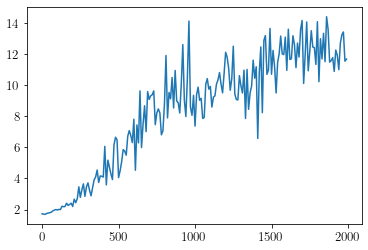

In [32]:
#Kantz-Rosenstein
def KantzRosenstein(X,eps,delta_n):

    x_triples = plongementTri(120,X)
    x_normal = x_triples[:,0]
    x_tau = x_triples[:,1]
    x_2tau = x_triples[:,2]
    
    size = len(x_normal)-delta_n

    #Choix aléatoire de points de l'attracteur
    N_centers = 20 #Nombre de voisinages 
    centers = rd.sample(range(size),N_centers)

    S = 0
    for i in centers:
        S_neighborhood = 0
        number_of_neighbors = 0
        for j in range(size):
            if sqrt(np.mean([(u-v)**2 for u,v in zip(x_triples[i,:],x_triples[j])])) < eps: #j est voisin de i
                number_of_neighbors +=1
                S_neighborhood += sqrt(np.sum([(u-v)**2 for u,v in zip(x_triples[i+delta_n,:],x_triples[j+delta_n])]))
        S += S_neighborhood/(number_of_neighbors-1) #i=j donc -1
        print(number_of_neighbors)
    S = S/N_centers
    
    return(S)

plt.figure()
S_values = []
for delta_n in tqdm(range(0,2000,10), position=0, leave=True):
    S_values.append(KantzRosenstein(X,1.5,delta_n))
plt.plot(range(0,2000,10),S_values)
plt.show()

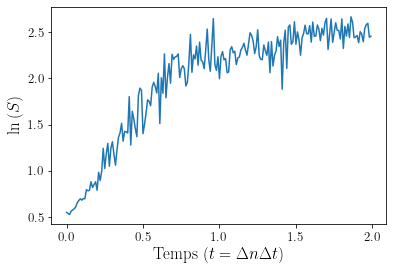

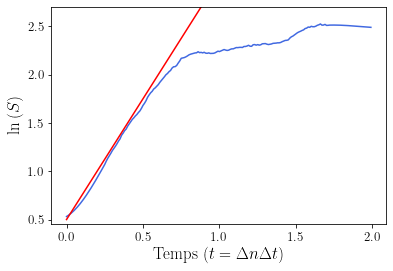

In [57]:
time = [value*1e-3 for value in range(0,2000,10)]

plt.figure()
plt.plot(time, np.log(S_values))
plt.xlabel(r'Temps $(t=\Delta n \Delta t)$')
plt.ylabel(r'$\ln{(S)}$')
plt.show()

plt.figure()
ax = plt.gca()
ax.set_ylim([0.45, 2.7])
plt.plot(time, savgol_filter(np.log(S_values),51,3), color='Royalblue')
plt.plot(time, [1.5/0.6*value+0.5 for value in time], color='red')
plt.xlabel(r'Temps $(t=\Delta n \Delta t)$')
plt.ylabel(r'$\ln{(S)}$')
plt.show()

In [ ]:
#Détermination de la dimension de l'attracteur étrange

X_cut = X[:20000]
data = plongementTri(120,X_cut)
x_normal = data[:,0]
x_tau = data[:,1]
x_2tau = data[:,2]
    
defcorr_modified(serie,eps,n_min):
        N_serie =  
        C = 0
        for i in range(N_serie):
            for j in range(i+n_min+1, N_serie):
                if sqrt(np.mean([(u-v)**2 for u,v in zip(data[i,:],data[j])])) < eps:
                    C+=1
        return(C*2/((len(x_normal)-n_min)**2))
                        